#Import Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog
from graphviz import Digraph
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#Download the Dataset

In [2]:
!curl -o mango_leaf_bd_dataset.zip https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hxsnvwty3r-1.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  103M  100  103M    0     0  11.0M      0  0:00:09  0:00:09 --:--:-- 15.0M


#Extract the Dataset

In [ ]:
!unzip /content/mango_leaf_bd_dataset.zip

In [4]:
!mv MangoLeafBD\ Dataset mangoLeafBDDataset

#Exploratory Data Analysis (EDA)

In [5]:
# Set the directory for the dataset
data_dir = '/content/mangoLeafBDDataset'

# Get the list of classes (folders)
classes = os.listdir(data_dir)

# Prepare lists to store image paths and labels
image_paths = []
labels = []

# Loop through each class folder
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        # Append image path and class label to lists
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Display the first few rows to inspect
print("Sample rows from the dataset:")
print(df.head())

# Check the distribution of classes
print("\nClass distribution:")
print(df['label'].value_counts())

Sample rows from the dataset:
                                          image_path     label
0  /content/mangoLeafBDDataset/Die Back/IMG_20211...  Die Back
1  /content/mangoLeafBDDataset/Die Back/20211129_...  Die Back
2  /content/mangoLeafBDDataset/Die Back/20211129_...  Die Back
3  /content/mangoLeafBDDataset/Die Back/20211129_...  Die Back
4  /content/mangoLeafBDDataset/Die Back/IMG_20211...  Die Back

Class distribution:
label
Die Back            500
Healthy             500
Gall Midge          500
Anthracnose         500
Bacterial Canker    500
Cutting Weevil      500
Powdery Mildew      500
Sooty Mould         500
Name: count, dtype: int64


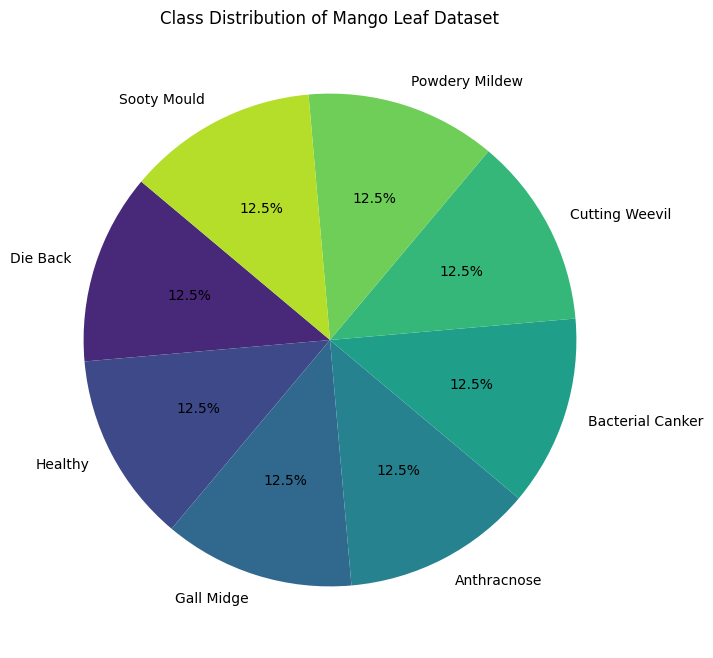

In [6]:
# Plot the class distribution as a pie chart
plt.figure(figsize=(10, 8))
df['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(classes)))
plt.title("Class Distribution of Mango Leaf Dataset")
plt.ylabel('')  # Hide the y-label for a cleaner look
plt.show()

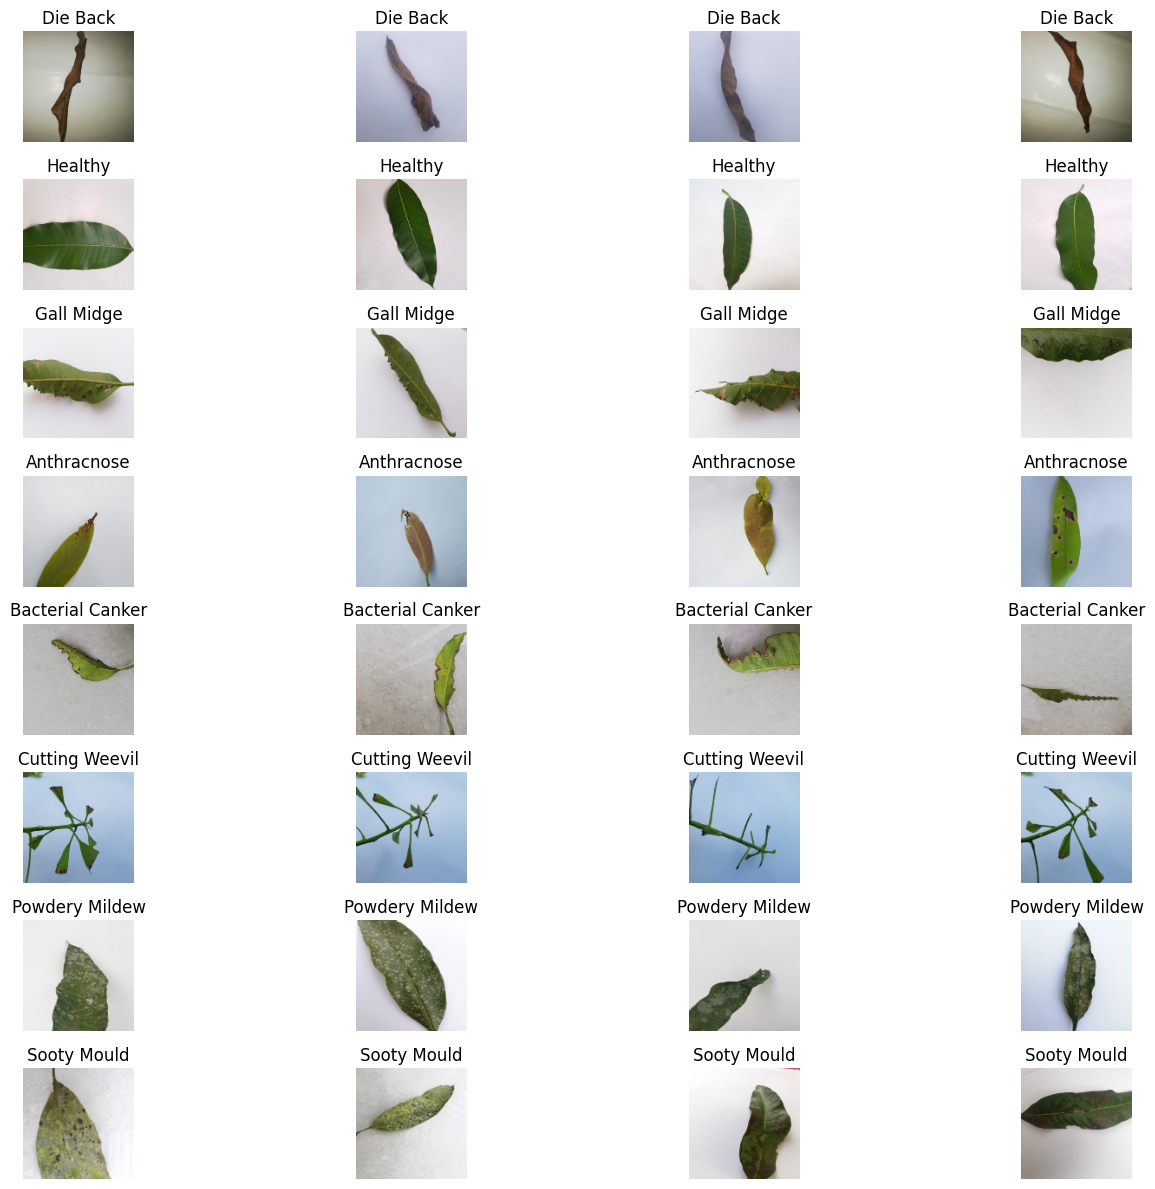

In [7]:
# Function to load an image and preprocess it
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    # Load the image in color (or you can convert to grayscale by passing cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(image_path)
    # Resize image to the target size
    img = cv2.resize(img, target_size)
    # Convert image to RGB format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Display a sample of images from each class
def display_sample_images(df, classes, sample_per_class=4):
    plt.figure(figsize=(15, 12))
    for idx, class_name in enumerate(classes):
        # Sample image paths from the current class
        sample_paths = df[df['label'] == class_name]['image_path'].sample(sample_per_class).values
        for i, img_path in enumerate(sample_paths):
            plt.subplot(len(classes), sample_per_class, idx * sample_per_class + i + 1)
            img = load_and_preprocess_image(img_path, target_size=(128, 128))
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)
    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(df, classes)

#Flatten Images for Feature Extraction

In [8]:
# Define the target size for resizing images
target_size = (64, 64)

# Function to flatten an image
def flatten_image(image_path, target_size=(64, 64)):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale for simplicity
    # Resize the image
    img = cv2.resize(img, target_size)
    # Flatten the image
    return img.flatten()

# Apply the flattening function to each image path
df['flattened_features'] = df['image_path'].apply(flatten_image)

# Convert the feature column to a numpy array for model input
X_flattened = np.array(df['flattened_features'].tolist())
y = df['label'].values  # Target labels

print("Shape of flattened features array:", X_flattened.shape)

Shape of flattened features array: (4000, 4096)


In [9]:
df.head()

,image_path,label,flattened_features
0,/content/mangoLeafBDDataset/Die Back/IMG_20211...,Die Back,"[179, 179, 178, 177, 177, 177, 177, 177, 177, ..."
1,/content/mangoLeafBDDataset/Die Back/20211129_...,Die Back,"[203, 202, 202, 201, 202, 201, 201, 202, 202, ..."
2,/content/mangoLeafBDDataset/Die Back/20211129_...,Die Back,"[217, 217, 216, 216, 216, 216, 215, 215, 215, ..."
3,/content/mangoLeafBDDataset/Die Back/20211129_...,Die Back,"[196, 195, 196, 195, 194, 194, 194, 194, 194, ..."
4,/content/mangoLeafBDDataset/Die Back/IMG_20211...,Die Back,"[177, 177, 176, 176, 176, 175, 175, 176, 176, ..."


In [10]:
print(df[0:1])

                                          image_path     label  \
0  /content/mangoLeafBDDataset/Die Back/IMG_20211...  Die Back   

                                  flattened_features  
0  [179, 179, 178, 177, 177, 177, 177, 177, 177, ...  


In [11]:
# # Convert the 'hog_features' column to a NumPy array
# X_hog = np.array(df['hog_features'].tolist())
# y = df['label'].values

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# Convert the 'flattened_features' column to a NumPy array
X_flattened = np.array(df['flattened_features'].tolist())
y = df['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree model
dt_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_classifier.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5913
Precision: 0.5887
Recall: 0.5913
F1 Score: 0.5878

Classification Report:
                   precision    recall  f1-score   support

     Anthracnose       0.55      0.53      0.54       100
Bacterial Canker       0.60      0.55      0.58       100
  Cutting Weevil       0.86      0.98      0.92       100
        Die Back       0.76      0.76      0.76       100
      Gall Midge       0.41      0.43      0.42       100
         Healthy       0.54      0.54      0.54       100
  Powdery Mildew       0.53      0.40      0.45       100
     Sooty Mould       0.46      0.54      0.50       100

        accuracy                           0.59       800
       macro avg       0.59      0.59      0.59       800
    weighted avg       0.59      0.59      0.59       800



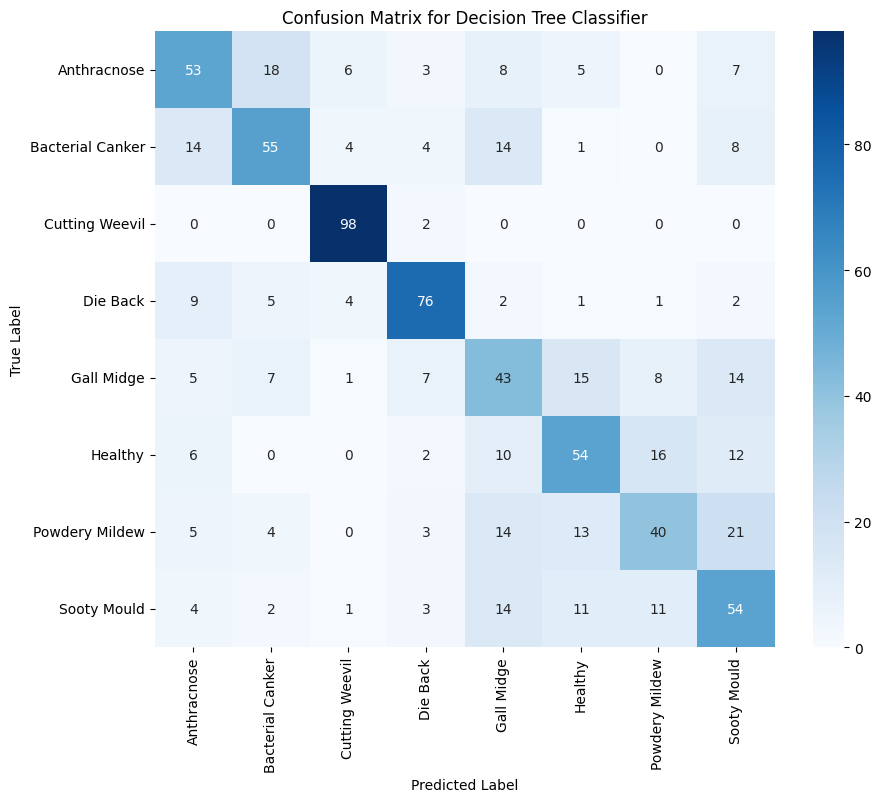

In [14]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dt_classifier.classes_, yticklabels=dt_classifier.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Decision Tree Classifier")
plt.show()

#Random Forest

In [15]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8150
Precision: 0.8157
Recall: 0.8150
F1 Score: 0.8144

Classification Report:
                   precision    recall  f1-score   support

     Anthracnose       0.71      0.75      0.73       100
Bacterial Canker       0.82      0.80      0.81       100
  Cutting Weevil       0.92      1.00      0.96       100
        Die Back       0.91      0.86      0.88       100
      Gall Midge       0.76      0.76      0.76       100
         Healthy       0.79      0.85      0.82       100
  Powdery Mildew       0.85      0.74      0.79       100
     Sooty Mould       0.77      0.76      0.76       100

        accuracy                           0.81       800
       macro avg       0.82      0.81      0.81       800
    weighted avg       0.82      0.81      0.81       800



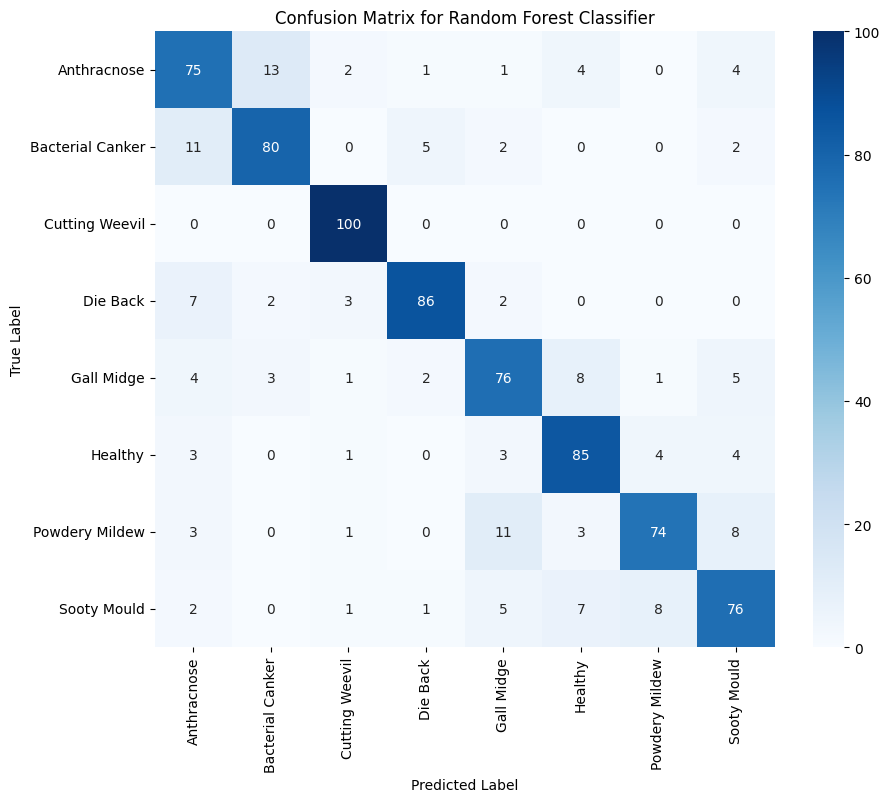

In [16]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()